# MLP using Pytorch

The goal of this model is to do a binary classification of income of greater than 50K or not. Using the Adult income dataset and Pytorch as the main library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch
from torch import nn

## Dataset Loading and Inspection

Now we'll load the dataset and check through the data.

In [2]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

data_train = pd.read_csv("AdultIncomeDataset/adult.data", header=None, names=col_names)
data_test = pd.read_csv("AdultIncomeDataset/adult.test", skiprows=1, header=None, names=col_names)

data_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data cleaning and Analysis

The provided dataset is not entirely clean and contains ' ?' for unkown values, which we need to fix by replacing them with NaN. Then we can drop these rows containing unkown values. Also to note is that we'll standardize our target variable income to 0 and 1. Then we'll analyze the data. 

income
0    22654
1     7508
Name: count, dtype: int64


C:\Users\parth\AppData\Local\Temp\ipykernel_16540\3827991300.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train["income"] = data_train["income"].replace(" <=50K", 0).replace(" >50K", 1).astype(int)
C:\Users\parth\AppData\Local\Temp\ipykernel_16540\3827991300.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_test["income"] = data_test["income"].replace(" <=50K.", 0).replace(" >50K.", 1).astype(int) #There is a dot in testing data


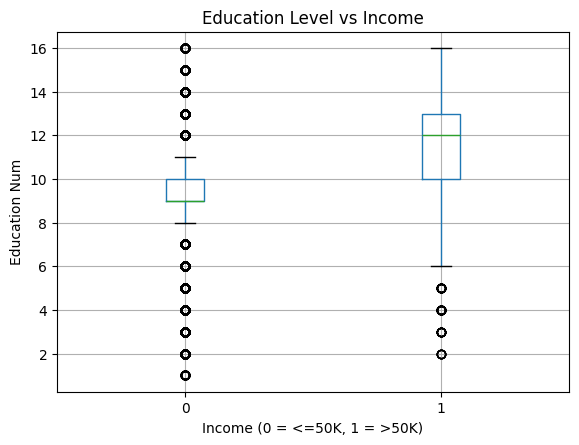

In [3]:
data_train.replace(" ?", np.nan, inplace=True)
data_train.dropna(inplace=True)

data_test.replace(" ?", np.nan, inplace=True)
data_test.dropna(inplace=True)

data_train["income"] = data_train["income"].replace(" <=50K", 0).replace(" >50K", 1).astype(int)

data_test["income"] = data_test["income"].replace(" <=50K.", 0).replace(" >50K.", 1).astype(int) #There is a dot in testing data

print(data_train["income"].value_counts())

data_train.boxplot(
    column="education_num",
    by="income"
)

plt.title("Education Level vs Income")
plt.suptitle("")  # removes automatic subtitle
plt.xlabel("Income (0 = <=50K, 1 = >50K)")
plt.ylabel("Education Num")
plt.show()



## Data Preprocessing

Now we'll prepare the data to feed to the neural network. We'll drop the redundant column `education` (since `education_num` already encodes the same info). We'll also use One-Hot Encoding for all the string inputs like `workclass`, `martial_status` etc. Then For our MLP we'll apply the StandardScaler across continous values like `age` and `education_num`.

In [4]:
data_train, data_val = train_test_split(data_train, test_size=0.2, stratify=data_train['income'])

data_train.drop(columns="education", inplace=True)
data_test.drop(columns="education", inplace=True)
data_val.drop(columns="education", inplace=True)

categorical_cols = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
numerical_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    sparse_threshold=0
)

X_train_proc = preprocessor.fit_transform(data_train)
X_val_proc = preprocessor.transform(data_val)
X_test_proc   = preprocessor.transform(data_test)


In [5]:
X_train_tensor = torch.tensor(X_train_proc, dtype=torch.float32)
y_train_tensor = torch.tensor(data_train["income"].values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_proc, dtype=torch.float32)
y_val_tensor = torch.tensor(data_val["income"].values, dtype=torch.float32).unsqueeze(1)


X_test_tensor = torch.tensor(X_test_proc, dtype=torch.float32)
y_test_tensor = torch.tensor(data_test["income"].values, dtype=torch.float32).unsqueeze(1)


## Model Architecture

Now, We'll be building a neural network using `torch.nn` using `adam` optimizer and `binary_crossentropy` loss function.

In [6]:
input_dim = X_train_proc.shape[1]

class IncomeClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),   # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),          # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1),            # Output layer
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = IncomeClassifier(input_dim)

num_negatives = (y_train_tensor == 0).sum()
num_positives = (y_train_tensor == 1).sum()
pos_weight_value = num_negatives / num_positives
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def binary_accuracy(y_pred, y_true):
    y_pred_class = (y_pred >= 0.5).float()
    return (y_pred_class == y_true).float().mean()



## Training the model

Now we'll create the training loop and proceed with training the neural network.

In [7]:
epochs = 100
batch_size = 128

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    y_pred = model(X_train_tensor)

    loss = criterion(y_pred, y_train_tensor)
    acc  = binary_accuracy(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)
        val_acc  = binary_accuracy(val_pred, y_val_tensor)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss: {loss:.4f} | Acc: {acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 01 | Loss: 1.0842 | Acc: 0.7382 | Val Loss: 1.0830 | Val Acc: 0.7537
Epoch 02 | Loss: 1.0831 | Acc: 0.7480 | Val Loss: 1.0818 | Val Acc: 0.7552
Epoch 03 | Loss: 1.0819 | Acc: 0.7513 | Val Loss: 1.0806 | Val Acc: 0.7555
Epoch 04 | Loss: 1.0807 | Acc: 0.7535 | Val Loss: 1.0794 | Val Acc: 0.7558
Epoch 05 | Loss: 1.0795 | Acc: 0.7539 | Val Loss: 1.0782 | Val Acc: 0.7558
Epoch 06 | Loss: 1.0783 | Acc: 0.7544 | Val Loss: 1.0769 | Val Acc: 0.7558
Epoch 07 | Loss: 1.0772 | Acc: 0.7546 | Val Loss: 1.0756 | Val Acc: 0.7558
Epoch 08 | Loss: 1.0758 | Acc: 0.7550 | Val Loss: 1.0743 | Val Acc: 0.7558
Epoch 09 | Loss: 1.0746 | Acc: 0.7550 | Val Loss: 1.0730 | Val Acc: 0.7558
Epoch 10 | Loss: 1.0734 | Acc: 0.7549 | Val Loss: 1.0715 | Val Acc: 0.7558
Epoch 11 | Loss: 1.0719 | Acc: 0.7555 | Val Loss: 1.0701 | Val Acc: 0.7558
Epoch 12 | Loss: 1.0708 | Acc: 0.7555 | Val Loss: 1.0685 | Val Acc: 0.7558
Epoch 13 | Loss: 1.0689 | Acc: 0.7569 | Val Loss: 1.0669 | Val Acc: 0.7558
Epoch 14 | Loss: 1.0673 |

## Evaluation Metrics

We'll now display the evaluation metrics for accuracy, confusion matrix and classification report.

Accuracy: 0.8279


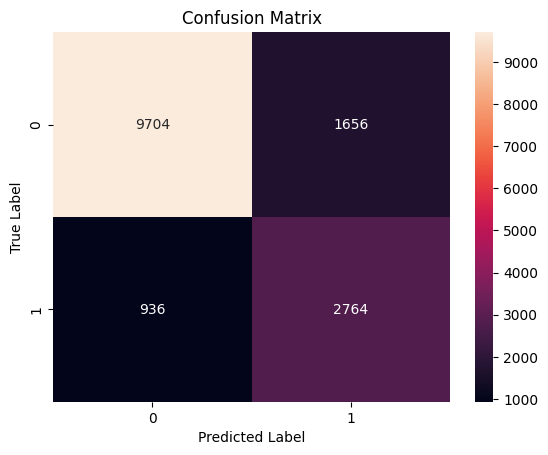

              precision    recall  f1-score   support

    Negative       0.91      0.85      0.88     11360
    Positive       0.63      0.75      0.68      3700

    accuracy                           0.83     15060
   macro avg       0.77      0.80      0.78     15060
weighted avg       0.84      0.83      0.83     15060



In [8]:
model.eval()
with torch.no_grad():
    y_prob = model(X_test_tensor).cpu().numpy().ravel()   
    y_pred = (y_prob >= 0.5).astype(int)                 

y_true = y_test_tensor.cpu().numpy().ravel()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

## Conclusion

As we can see, our MLP achives 85% accuracy which is fairly good. Also, it seems to be better at predicitng cases with less income than higher icome as seen by recall in both cases. Overall the model is conservative in predicting high income.